In [35]:
# from transformers import AutoTokenizer

!pip install transformers clean-text
!pip install fuzzywuzzy
!pip install wordcloud matplotlib

In [1]:
import pandas as pd
from docx import Document
import re
from collections import Counter
from textblob import TextBlob
import spacy
import nltk
import gensim
import string
import matplotlib.pyplot as plt
import scipy.sparse as sp
import os
from tqdm import tqdm

from fuzzywuzzy import fuzz
from wordcloud import WordCloud

# from transformers import AutoTokenizer
from cleantext import clean
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

nlp = spacy.load('en_core_web_sm')

def read_docx(df_cseg, i):
    doc = df_cseg.Segment[i]
    data = {'Person': [], 'Text': [], 'Time': [],
            'Code': df_cseg['Code'][i].split('>')[-1].strip(),
            'Area': df_cseg['Area'][i],
            'Coverage': df_cseg['Coverage %'][i]}
    for paragraph in doc.split('\n'):
        # Use regular expression to find text after "\t[hh:mm:ss]\t"
        match = re.search(r'\t(\d{2}:\d{2}:\d{2})\t', paragraph)
        if match:
            start_index = match.start()
            end_index = match.end()
            time = match.group(1)
            part_before_time = paragraph[:start_index].strip()
            text_after_time = paragraph[end_index:]
            data['Person'].append(part_before_time)
            data['Text'].append(text_after_time)
            data['Time'].append(time)
    return pd.DataFrame(data)

def extract_name_folder(input_string):
    pattern = r'NLP Coding - ([A-Za-z\s]+)\.mx24\.xlsx'
    match = re.search(pattern, input_string)

    if match:
        name = match.group(1).lower()
        return re.sub(r'[-_ ]', '', name)
    else:
        print("No name found in the string: ", input_string)

/Users/rishabh/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [2]:
num_coded_segs = []
num_codes = []

folder_path = 'NLP coded = parsed = interview Q coded .xlsx & .mx24 files'
df_combo = pd.DataFrame()

file_paths = []

for filename in os.listdir(folder_path):
    full_path = os.path.join(folder_path, filename)
    
    if os.path.isfile(full_path) and filename.endswith('.xlsx'):
        file_paths.append(folder_path + "/" + filename)
        
df_demog = pd.read_excel('Demographic_Data.xlsx', sheet_name='Sheet1')
df_demog['Full Name'] = df_demog['First Name'] + df_demog['Last Name']
df_demog['Full Name'] = df_demog['Full Name'].apply(lambda x: re.sub(r'[-_ ]', '', x.lower()))
        
print("Number of files in queue - ", len(file_paths))

for item in tqdm(range(len(file_paths))):
    
    try: 
        file_path = file_paths[item]
        
        #extract demographics
        term_to_find = extract_name_folder(file_path)
        threshold = 80
        for idx, value in df_demog['Full Name'].items():
            similarity = fuzz.ratio(term_to_find, value)
            if similarity >= threshold:
                idx_demog = idx

        df_csys = pd.read_excel(file_path, sheet_name='Code System').fillna({'Code System': '', 'Unnamed: 1': '', 'Unnamed: 2': '', 'Unnamed: 3': ''})
        df_csys['Code System'] = df_csys['Code System'].astype(str) + df_csys['Unnamed: 1'].astype(str) + df_csys['Unnamed: 2'].astype(str) + df_csys['Unnamed: 3'].astype(str)
        df_csys = df_csys[['Code System', 'Frequency']]

        num_coded_segs.append(df_csys['Frequency'][0])
        df_csys = df_csys.drop(index=0).reset_index(drop=True)
        num_codes.append(len(df_csys))

        df = pd.DataFrame()
        df_cseg = pd.read_excel(file_path, sheet_name='Coded Segments')
        for i in range(len(df_cseg)):
            df = pd.concat([df, read_docx(df_cseg, i)], ignore_index=True)
            df['Theater'] = df_demog.iloc[:, 2][idx_demog]
            df['Length'] = df_demog.iloc[:, 4][idx_demog]
            df['Role'] = df_demog.iloc[:, 5][idx_demog]
            df['Location'] = df_demog.iloc[:, 7][idx_demog]
            df['Undergrad Year'] = df_demog.iloc[:, 8][idx_demog].astype(int)
            df['Perceived Gender'] = df_demog.iloc[:, 15][idx_demog]
            df['Location Diff Residency'] = df_demog.iloc[:, 18][idx_demog]
            df['File'] = file_path

        df_combo = pd.concat([df_combo, df], ignore_index=True)
        
    except:
        print("File failed - ", file_path)
        pass

Number of files in queue -  130


 49%|████▉     | 64/130 [00:06<00:05, 12.21it/s]

File failed -  NLP coded = parsed = interview Q coded .xlsx & .mx24 files/NLP Coding - Kumar Kuldeep.mx24.xlsx


100%|██████████| 130/130 [00:13<00:00,  9.83it/s]


In [3]:
# Additional Filters

df_combo = df_combo[(df_combo.Role != 'Academic') &
         (df_combo.Role != 'Fellowship') &
         (df_combo.Role != 'Graduate Teaching Assistant') &
         (df_combo.Role != 'Group Supervisor') &
         (df_combo.Role != 'Junior Leader Fellow') &
         (df_combo.Role != 'Lecturer') &
         (df_combo.Role != 'Senior Engineer') &
         (df_combo.Role != 'Senior Lecturer') &
         (df_combo.Role != 'Software Engineer')
         ]

df_combo['Role'] = df_combo['Role'].replace(['Asisstant Professor '], 'Assistant Professor')
df_combo['Role'] = df_combo['Role'].replace(['Junior Postdoc Fellow',
                                                     'Posdoctoral Fellow',
                                                     'Postdoc',
                                                     'Postdoc Fellow',
                                                     'Postdoc Researcher',
                                                     'Postdoctoral Fellow ',
                                                     'Postdoctoral Research Fellow',
                                                     'Postdoctoral Researcher',
                                                     'Postdoctorate ',
                                                     'Postdoctural Fellow',
                                                     'Postdoctural Researcher'
                                                    ], 'Postdoctoral Fellow')
df_combo['Role'] = df_combo['Role'].replace(['Research Profesor ',
                                                     'Research Professor',
                                                     'Research Professor ',
                                                    ], 'Professor')
df_combo['Role'] = df_combo['Role'].replace(['Permenant Researcher',
                                                     'Senior Researcher',
                                                     'Third Level Researcher',
                                                     'Visiting Researcher',
                                                    ], 'Researcher')

In [4]:
print('Length of Dataset = ', len(df_combo))
df_combo.head()

Length of Dataset =  20584


,Person,Text,Time,Code,Area,Coverage,Theater,Length,Role,Location,Undergrad Year,Perceived Gender,Location Diff Residency,File
0,Interviewer,"Yeah. Okay, [laughs] okay. That works. Um, jus...",00:00:24,Question 2-b,203,0.232149,Genetics,93,Postdoctoral Fellow,Norway,2007,Female,NaN,NLP coded = parsed = interview Q coded .xlsx &...
1,Interviewee,"Um, evolutionary ecology, I think would be --",00:00:34,Question 2-b,203,0.232149,Genetics,93,Postdoctoral Fellow,Norway,2007,Female,NaN,NLP coded = parsed = interview Q coded .xlsx &...
2,Interviewer,"Okay. And, um, what is your citizenship?",00:00:40,Question 2-c,370,0.423128,Genetics,93,Postdoctoral Fellow,Norway,2007,Female,NaN,NLP coded = parsed = interview Q coded .xlsx &...
3,Interviewee,"Um, [laughs] it's complicated, but Brazilian I...",00:00:44,Question 2-c,370,0.423128,Genetics,93,Postdoctoral Fellow,Norway,2007,Female,NaN,NLP coded = parsed = interview Q coded .xlsx &...
4,Interviewer,"Um, --",00:00:55,Question 2-c,370,0.423128,Genetics,93,Postdoctoral Fellow,Norway,2007,Female,NaN,NLP coded = parsed = interview Q coded .xlsx &...


In [5]:
df_combo_filtered = df_combo[df_combo['Code'].str.match(r'^Question \d+-[a-zA-Z]$')]
df_combo_filtered = df_combo_filtered[df_combo_filtered['Person'] == 'Interviewee']
print('Length of Filtered Dataset = ', len(df_combo_filtered))
df_combo_filtered.head()

Length of Filtered Dataset =  6463


,Person,Text,Time,Code,Area,Coverage,Theater,Length,Role,Location,Undergrad Year,Perceived Gender,Location Diff Residency,File
1,Interviewee,"Um, evolutionary ecology, I think would be --",00:00:34,Question 2-b,203,0.232149,Genetics,93,Postdoctoral Fellow,Norway,2007,Female,NaN,NLP coded = parsed = interview Q coded .xlsx &...
3,Interviewee,"Um, [laughs] it's complicated, but Brazilian I...",00:00:44,Question 2-c,370,0.423128,Genetics,93,Postdoctoral Fellow,Norway,2007,Female,NaN,NLP coded = parsed = interview Q coded .xlsx &...
5,Interviewee,"And I -- yeah, I did my undergrads in Brazil, ...",00:00:55,Question 2-c,370,0.423128,Genetics,93,Postdoctoral Fellow,Norway,2007,Female,NaN,NLP coded = parsed = interview Q coded .xlsx &...
7,Interviewee,-- and moved to the US for my PhD.,00:00:59,Question 2-c,370,0.423128,Genetics,93,Postdoctoral Fellow,Norway,2007,Female,NaN,NLP coded = parsed = interview Q coded .xlsx &...
9,Interviewee,Norway.,00:01:05,Question 2-d,78,0.089200,Genetics,93,Postdoctoral Fellow,Norway,2007,Female,NaN,NLP coded = parsed = interview Q coded .xlsx &...


In [6]:
custom_stop_words ={# Common
                    'think', 'people', 'know', 'want', 'like', 'yeah', 'right', 'way', 'like', 'you', 
                    'okay', 'well','research', 'science', 'kind', 'mean', 'sort', 'kind', 'see', 'good', 'lot', 'come',
                    'important', 'thing', 'field', 'thing', 'maybe', 'true', 'use', 'lot', 'work', 'lot', 'say', 'try',
                    # Fillers
                    'um', 'uh', 'mm', 'hmm', 'yes', 'nt', 's', 'm', 'ah', 'oh', 've', 'so', 'hm', 'mhm', 'd',
                    'alright', 'basically', 'actully', 'literally',
                    # Conjunctions
                    "and", "but", "if", "or", "so", "nor", "for", "yet", "although", "because", "since", 
                    "unless", "while", "whereas", "though", "either", "neither", "whether",
                    # Prepositions
                    "in", "on", "at", "by", "with", "about", "against", "between", "into", "through", "during", 
                    "before", "after", "above", "below", "under", "over", "of", "to", "from", "up", "down", 
                    "about", "around", "upon", "within", "without", "towards", "upon",
                    # Pronouns
                    "I", "you", "he", "she", "it", "we", "they", "me", "him", "her", "us", "them", "my", "your", 
                    "his", "its", "our", "their", "mine", "yours", "hers", "ours", "theirs",
                    # Auxiliary verbs (to-be, to-have, modals)
                    "is", "am", "are", "was", "were", "be", "been", "being", "have", "has", "had", "do", "does", 
                    "did", "can", "could", "will", "would", "shall", "should", "may", "might", "must", "ought",
                    # Articles and determiners
                    "a", "an", "the", "this", "that", "these", "those", "any", "some", "many", "much", "few", 
                    "several", "all", "no", "none", "every", "each", "both", "either", "neither",
                    # Other functional words
                    "there", "here", "where", "when", "how", "why", "what", "which", "who", "whom", "whose", 
                    "than", "just", "only", "very", "too", "enough", "even", "not", "n't", "as", "such"
                    }
for word in custom_stop_words:
    nlp.vocab[word].is_stop = True

def clean_and_get_common_words(text, n=3):
    text = text.lower()  # Convert to lowercase
    # text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\[.*?\]', '', text)  # Remove non-verbal markers
    text = re.sub(r'\d{1,2}:\d{2}(:\d{2})?', '', text)  # Remove timestamps
    text = re.sub(r'\w+:\s', '', text)  # Remove speaker labels
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    doc = nlp(text)
    cleaned_text = ' '.join([token.text for token in doc if not token.is_stop])
    return cleaned_text

df_combo_filtered['cleaned_Text'] = df_combo_filtered['Text'].apply(clean_and_get_common_words)

In [7]:
from nltk.stem import WordNetLemmatizer

In [8]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df_combo_filtered['tokenized_words'] = df_combo_filtered['cleaned_Text'].apply(lambda text: lemmatize_tokens(word_tokenize(text)))

df_combo_filtered = df_combo_filtered.drop(['cleaned_Text'], axis=1)

In [9]:
df_combo_filtered['Code_agg'] = df_combo_filtered['Code'].apply(lambda x: x.split('-')[0])
df_combo_filtered

,Person,Text,Time,Code,Area,Coverage,Theater,Length,Role,Location,Undergrad Year,Perceived Gender,Location Diff Residency,File,tokenized_words,Code_agg
1,Interviewee,"Um, evolutionary ecology, I think would be --",00:00:34,Question 2-b,203,0.232149,Genetics,93,Postdoctoral Fellow,Norway,2007,Female,NaN,NLP coded = parsed = interview Q coded .xlsx &...,"[evolutionary, ecology]",Question 2
3,Interviewee,"Um, [laughs] it's complicated, but Brazilian I...",00:00:44,Question 2-c,370,0.423128,Genetics,93,Postdoctoral Fellow,Norway,2007,Female,NaN,NLP coded = parsed = interview Q coded .xlsx &...,"[complicated, brazilian, best, description]",Question 2
5,Interviewee,"And I -- yeah, I did my undergrads in Brazil, ...",00:00:55,Question 2-c,370,0.423128,Genetics,93,Postdoctoral Fellow,Norway,2007,Female,NaN,NLP coded = parsed = interview Q coded .xlsx &...,"[undergrad, brazil]",Question 2
7,Interviewee,-- and moved to the US for my PhD.,00:00:59,Question 2-c,370,0.423128,Genetics,93,Postdoctoral Fellow,Norway,2007,Female,NaN,NLP coded = parsed = interview Q coded .xlsx &...,"[moved, phd]",Question 2
9,Interviewee,Norway.,00:01:05,Question 2-d,78,0.089200,Genetics,93,Postdoctoral Fellow,Norway,2007,Female,NaN,NLP coded = parsed = interview Q coded .xlsx &...,[norway],Question 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21813,Interviewee,"Uh, at least flag that publicly and, and make ...",01:06:17,Question 13-a,1160,1.997486,AI,75,Postdoctoral Fellow,Canada,2014,Male,NaN,NLP coded = parsed = interview Q coded .xlsx &...,"[flag, publicly, statement, intention, scienti...",Question 13
21815,Interviewee,"I think it's quite, it's quite a close collabo...",01:07:40,Question 13-b,647,1.114115,AI,75,Postdoctoral Fellow,Canada,2014,Male,NaN,NLP coded = parsed = interview Q coded .xlsx &...,"[close, collaboration, collaboration, best, wo...",Question 13
21819,Interviewee,"Mm. No, I don't, I don't think, I, I mean, uh,...",01:10:02,Question 13-c,830,1.429236,AI,75,Postdoctoral Fellow,Canada,2014,Male,NaN,NLP coded = parsed = interview Q coded .xlsx &...,"[position, comparison, canadian, situation, ci...",Question 13
21821,Interviewee,"Mm. Well, same as what I said before. I think,...",01:10:55,Question 13-d,1637,2.818866,AI,75,Postdoctoral Fellow,Canada,2014,Male,NaN,NLP coded = parsed = interview Q coded .xlsx &...,"[said, strong, statement, clear, opposition, a...",Question 13


In [59]:
# df_combo_filtered.to_pickle("df_combo_filtered.pkl")

# Grouping Analysis

## Grouping by NLP Codes

In [10]:
df_test = df_combo_filtered[df_combo_filtered.Person == 'Interviewee'].groupby('Code_agg').agg({
    'tokenized_words': lambda x: sum(x, []),
    'Code_agg': 'count'
}).rename(columns={'Code_agg': 'Response Count'}).reset_index()

# 1. Number of words in text
df_test['Word Count'] = df_test['tokenized_words'].apply(lambda x: len(x))

# 2. Commonly used words (without stopwords and punctuation)
def clean_and_get_common_words(text, n=3):
    return Counter(text).most_common(n)

df_test['Common Words'] = df_test['tokenized_words'].apply(clean_and_get_common_words)

# 3. Sentiment analysis using TextBlob
df_test['Sentiment'] = df_test['tokenized_words'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)

In [12]:
df_test

,Code_agg,tokenized_words,Response Count,Word Count,Common Words,Sentiment
0,Question 10,"[remember, started, grad, school, thing, neede...",434,8357,"[(competition, 222), (collaboration, 150), (di...",0.075434
1,Question 11,"[definitely, respect, let, best, word, choose,...",263,4059,"[(bias, 83), (researcher, 58), (country, 40)]",0.063008
2,Question 12,"[guess, little, freedom, transition, globalize...",672,12532,"[(country, 235), (world, 138), (different, 130)]",0.056304
3,Question 13,"[difficult, struggling, option, suppose, depen...",1022,17858,"[(government, 440), (scientist, 262), (country...",0.054639
4,Question 2,"[evolutionary, ecology, complicated, brazilian...",66,651,"[(physic, 15), (year, 11), (model, 9)]",0.103005
5,Question 3,"[driven, outside, thing, curious, interested, ...",867,21037,"[(thing, 201), (year, 166), (working, 165)]",0.110717
6,Question 4,"[look, personally, validated, area, reaching, ...",760,15949,"[(impact, 331), (country, 198), (different, 194)]",0.104454
7,Question 5,"[sure, journal, conference, engage, bit, outre...",649,12214,"[(conference, 538), (journal, 527), (paper, 211)]",0.068361
8,Question 6,"[mmhmm, guess, close, area, genomics, technolo...",673,14294,"[(data, 159), (year, 155), (thing, 116)]",0.094342
9,Question 7,"[sure, subjective, cost, fact, value, thing, i...",330,6729,"[(different, 193), (place, 87), (cost, 78)]",0.108418


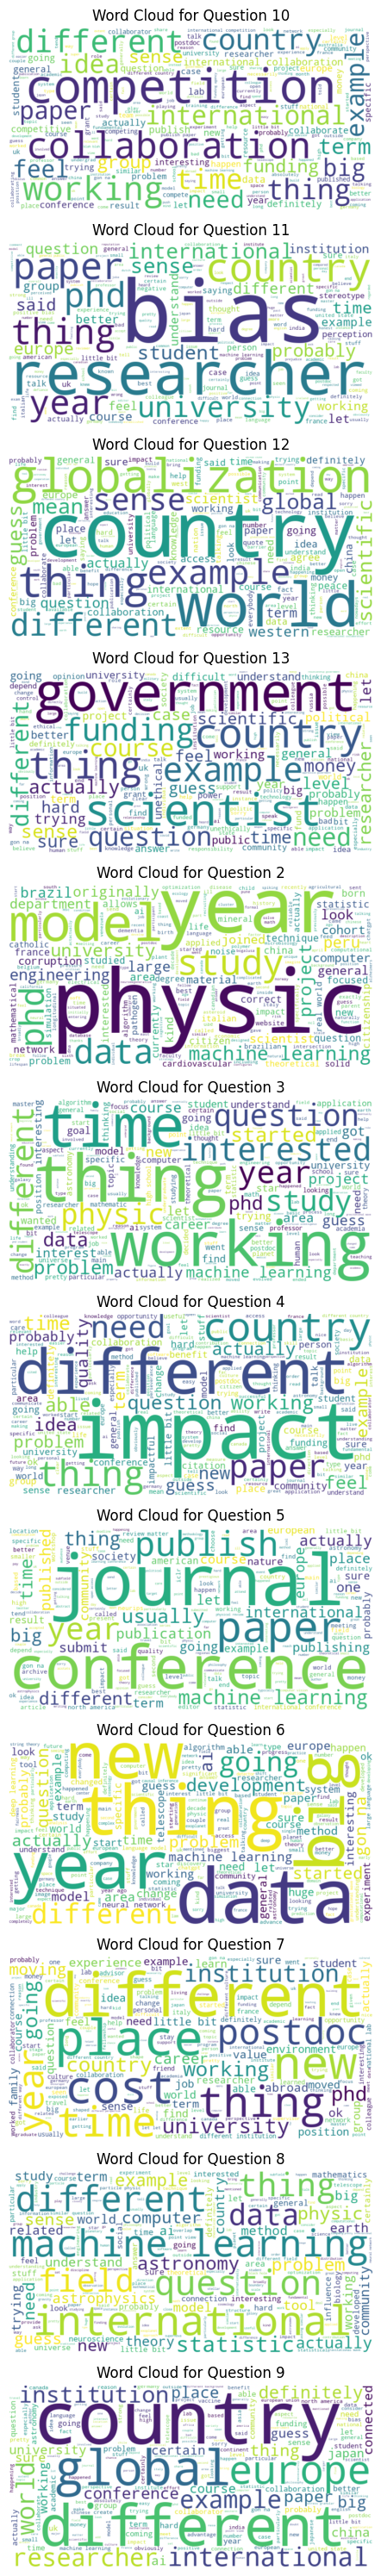

In [11]:
# Create a WordCloud for each list of words in the DataFrame
fig, axes = plt.subplots(len(df_test), 1, figsize=(10, 30))

# Loop through each row and generate a word cloud for each tokenized list
for i, (code, tokens) in enumerate(zip(df_test['Code_agg'], df_test['tokenized_words'])):
    # Join the list of words into a single string for wordcloud processing
    text = ' '.join(tokens)
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    # Plot the word cloud on the appropriate subplot axis
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')  # Turn off axis
    axes[i].set_title(f"Word Cloud for {code}")  # Title with Code

# Show the word clouds
plt.tight_layout()
plt.show()

## Grouping by Theater

In [14]:
df_file_grp = df_combo_filtered[df_combo_filtered.Person == 'Interviewee'].groupby('File').agg({
    'tokenized_words': lambda x: sum(x, []),
    'File': 'count',
    'Theater': 'first',
    'Role': 'first',
    'Location': 'first',
    'Undergrad Year': 'first',
    'Perceived Gender': 'first'
}).rename(columns={'File': 'Response Count'}).reset_index()

In [15]:
df_test_place = df_file_grp.groupby('Theater').agg({
    'tokenized_words': lambda x: sum(x, []),
    'Theater': 'count',
    'Role': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True)),
    'Location': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True)),
    'Undergrad Year': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True)),
    'Perceived Gender': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True))
}).rename(columns={'Theater': 'Response Count'}).reset_index()

# 1. Number of words in text
df_test_place['Word Count'] = df_test_place['tokenized_words'].apply(lambda x: len(x))

# 2. Commonly used words (without stopwords and punctuation)
def clean_and_get_common_words(text, n=3):
    return Counter(text).most_common(n)

df_test_place['Common Words'] = df_test_place['tokenized_words'].apply(clean_and_get_common_words)

# 3. Sentiment analysis using TextBlob
df_test_place['Sentiment'] = df_test_place['tokenized_words'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)

In [25]:
df_test_place.Location[3]

{'United States': 15,
 'France': 6,
 'England': 3,
 'Australia': 3,
 'Italy': 3,
 'Netherlands': 3,
 'Spain': 3,
 'Brazil': 3,
 'Germany': 2,
 'Portugal ': 2,
 'Hungary': 2,
 'Poland': 1,
 'Ireland': 1,
 'Canada': 1,
 None: 1,
 'United Kingdom': 1}

In [51]:
df_test_place

,Theater,tokenized_words,Response Count,Role,Location,Undergrad Year,Perceived Gender,Word Count,Common Words,Sentiment
0,AI,"[interested, small, interested, solving, probl...",46,"{'Postdoctoral Fellow': 14, 'Assistant Profess...","{'United States': 20, 'Canada': 3, 'Czechia': ...","{2014: 5, 2012: 5, 2015: 5, -92233720368547758...","{'Male': 42, 'Female': 4}",54622,"[(different, 515), (thing, 478), (learning, 477)]",0.090580
1,Genetics,"[started, kinda, best, decision, year, high, s...",7,"{'Postdoctoral Fellow': 4, 'Professor': 2, 'As...","{'Sweden': 3, 'United States': 2, 'Norway': 1,...","{2012: 3, 1981: 2, 2007: 1, 2005: 1}","{'Male': 4, 'Female': 3}",10683,"[(thing, 105), (actually, 82), (bit, 79)]",0.067077
2,Social,"[best, describes, economic, history, economic,...",1,{'Postdoctoral Fellow': 1},{'Italy': 1},{2016: 1},{'Male': 1},1366,"[(economic, 29), (history, 26), (italian, 26)]",0.076231
3,Space,"[career, path, wanted, interest, astronomy, as...",50,"{'Postdoctoral Fellow': 18, 'Professor': 12, '...","{'United States': 15, 'France': 6, 'England': ...","{-9223372036854775808: 8, 2013: 5, 2016: 3, 20...","{'Male': 33, 'Female': 16, None: 1}",58099,"[(different, 631), (country, 554), (thing, 490)]",0.076805


## Grouping by Role

In [52]:
df_test_role = df_file_grp.groupby('Role').agg({
    'tokenized_words': lambda x: sum(x, []),
    'Role': 'count',
    'Theater': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True)),
    'Location': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True)),
    'Undergrad Year': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True)),
    'Perceived Gender': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True))
}).rename(columns={'Role': 'Response Count'}).reset_index()

# 1. Number of words in text
df_test_role['Word Count'] = df_test_role['tokenized_words'].apply(lambda x: len(x))

# 2. Commonly used words (without stopwords and punctuation)
def clean_and_get_common_words(text, n=3):
    return Counter(text).most_common(n)

df_test_role['Common Words'] = df_test_role['tokenized_words'].apply(clean_and_get_common_words)

# 3. Sentiment analysis using TextBlob
df_test_role['Sentiment'] = df_test_role['tokenized_words'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)

In [53]:
df_test_role

,Role,tokenized_words,Response Count,Theater,Location,Undergrad Year,Perceived Gender,Word Count,Common Words,Sentiment
0,Assistant Professor,"[ok, ill, short, long, story, believe, researc...",16,"{'AI': 14, 'Space': 2}","{'United States': 9, 'Czechia': 2, 'Hungary': ...","{2012: 4, -9223372036854775808: 3, 2008: 2, 20...","{'Male': 12, 'Female': 4}",17805,"[(different, 228), (country, 168), (conference...",0.075720
1,Associate Professor,"[sure, going, exactly, precisely, answer, ques...",6,"{'AI': 4, 'Genetics': 1, 'Space': 1}","{'United States': 2, 'Italy': 1, 'Taiwan': 1, ...","{2005: 3, 1994: 1, 1997: 1, 2000: 1}",{'Male': 6},7925,"[(thing, 82), (year, 61), (let, 58)]",0.076292
2,Postdoctoral Fellow,"[career, path, wanted, interest, astronomy, as...",37,"{'Space': 18, 'AI': 14, 'Genetics': 4, 'Social...","{'United States': 8, 'France': 6, 'Sweden': 4,...","{2012: 5, 2016: 4, 2017: 4, 2013: 4, 2011: 4, ...","{'Male': 27, 'Female': 10}",45804,"[(thing, 471), (different, 428), (country, 373)]",0.082023
3,Professor,"[long, story, nontraditional, firstgeneration,...",18,"{'Space': 12, 'AI': 4, 'Genetics': 2}","{'United States': 10, 'Netherlands': 2, 'Hunga...","{1991: 5, -9223372036854775808: 3, 1981: 2, 19...","{'Male': 16, 'Female': 2}",23252,"[(different, 209), (year, 183), (thing, 165)]",0.094548
4,Project Assistant,"[interest, interested, problemsolving, tacklin...",1,{'AI': 1},{'Austria': 1},{2006: 1},{'Male': 1},1048,"[(actually, 24), (certain, 18), (bit, 15)]",0.087406
5,Research Associate,"[moment, particularly, looking, data, informat...",2,{'AI': 2},"{'England': 1, 'United States': 1}","{2013: 1, 2004: 1}","{'Male': 1, 'Female': 1}",2333,"[(machine, 35), (learning, 35), (probably, 28)]",0.032181
6,Research Fellow,"[phd, electrical, engineering, affiliated, app...",2,"{'AI': 1, 'Space': 1}","{'Spain': 1, 'England': 1}","{2002: 1, 2012: 1}",{'Male': 2},2374,"[(question, 25), (data, 24), (sense, 22)]",0.076742
7,Research Scientist,"[fascinated, child, grade, school, little, rem...",1,{'Space': 1},{'United States': 1},{1973: 1},{'Male': 1},625,"[(scientist, 22), (planet, 10), (climate, 10)]",0.062733
8,Research Staff,"[italian, started, young, 10, year, old, stuff...",1,{'Space': 1},{'Italy': 1},{2006: 1},{'Male': 1},1640,"[(different, 57), (level, 27), (country, 26)]",0.019794
9,Researcher,"[interested, small, interested, solving, probl...",12,"{'Space': 9, 'AI': 3}","{'United States': 3, 'Italy': 2, 'Portugal ': ...","{-9223372036854775808: 3, 2009: 2, 2013: 2, 20...","{'Male': 9, 'Female': 3}",12789,"[(country, 168), (different, 142), (time, 111)]",0.074612


## Grouping by Location

In [54]:
df_test_loc = df_file_grp.groupby('Location').agg({
    'tokenized_words': lambda x: sum(x, []),
    'Location': 'count',
    'Theater': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True)),
    'Role': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True)),
    'Undergrad Year': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True)),
    'Perceived Gender': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True))
}).rename(columns={'Location': 'Response Count'}).reset_index()

# 1. Number of words in text
df_test_loc['Word Count'] = df_test_loc['tokenized_words'].apply(lambda x: len(x))

# 2. Commonly used words (without stopwords and punctuation)
def clean_and_get_common_words(text, n=3):
    return Counter(text).most_common(n)

df_test_loc['Common Words'] = df_test_loc['tokenized_words'].apply(clean_and_get_common_words)

# 3. Sentiment analysis using TextBlob
df_test_loc['Sentiment'] = df_test_loc['tokenized_words'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)

In [55]:
df_test_loc

,Location,tokenized_words,Response Count,Theater,Role,Undergrad Year,Perceived Gender,Word Count,Common Words,Sentiment
0,Australia,"[guess, winding, winding, path, ended, working...",3,{'Space': 3},"{'Senior Lecturer ': 2, 'Senior Research Fello...","{2002: 2, 2010: 1}","{'Female': 2, 'Male': 1}",3818,"[(term, 37), (year, 31), (astronomy, 29)]",0.108664
1,Austria,"[interest, interested, problemsolving, tacklin...",1,{'AI': 1},{'Project Assistant': 1},{2006: 1},{'Male': 1},1048,"[(actually, 24), (certain, 18), (bit, 15)]",0.087406
2,Brazil,"[life, curious, universe, mathematics, physic,...",4,"{'Space': 3, 'AI': 1}",{'Postdoctoral Fellow': 4},"{1999: 2, 2011: 1, 2002: 1}","{'Male': 2, 'Female': 2}",4951,"[(different, 53), (thing, 49), (need, 43)]",0.068314
3,Canada,"[interested, small, interested, solving, probl...",4,"{'AI': 3, 'Space': 1}","{'Postdoctoral Fellow': 2, 'Researcher': 1, 'P...","{2009: 1, 2014: 1, 1991: 1, 2013: 1}",{'Male': 4},4636,"[(example, 54), (different, 49), (canada, 48)]",0.070764
4,China,"[20, 30, year, ago, undergraduate, program, fi...",1,{'AI': 1},{'Professor': 1},{1991: 1},{'Male': 1},2011,"[(ok, 133), (different, 32), (time, 26)]",0.214644
5,Czechia,"[ok, ill, short, long, story, believe, researc...",2,{'AI': 2},{'Assistant Professor': 2},{2008: 2},{'Male': 2},1826,"[(statistic, 26), (ok, 25), (different, 25)]",0.082553
6,England,"[interested, academia, guess, drawn, mathemati...",4,"{'Space': 3, 'AI': 1}","{'Postdoctoral Fellow': 1, 'Professor': 1, 'Re...","{2016: 1, 1986: 1, 2012: 1, 2013: 1}",{'Male': 4},5062,"[(thing, 67), (term, 64), (different, 53)]",0.103297
7,France,"[question, ok, actually, difficult, question, ...",7,"{'Space': 6, 'AI': 1}","{'Postdoctoral Fellow': 6, 'Professor': 1}","{2011: 2, 2012: 2, 2017: 1, -92233720368547758...","{'Male': 5, 'Female': 2}",8701,"[(different, 76), (journal, 70), (country, 68)]",0.067306
8,Germany,"[interested, academic, career, year, bachelor,...",4,"{'Space': 2, 'AI': 2}",{'Postdoctoral Fellow': 4},"{2016: 2, 2015: 2}","{'Female': 2, 'Male': 2}",4600,"[(journal, 47), (country, 40), (thing, 39)]",0.092793
9,Greece,"[interested, year, year, undergraduate, studen...",1,{'AI': 1},{'Associate Professor': 1},{2000: 1},{'Male': 1},1515,"[(conference, 27), (year, 21), (phd, 20)]",0.062545


## Grouping by Gender

In [56]:
df_test_gender = df_file_grp.groupby('Perceived Gender').agg({
    'tokenized_words': lambda x: sum(x, []),
    'Perceived Gender': 'count',
    'Theater': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True)),
    'Location': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True)),
    'Undergrad Year': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True)),
    'Role': lambda x: dict(sorted(dict(Counter(x)).items(), key=lambda item: item[1], reverse=True))
}).rename(columns={'Perceived Gender': 'Response Count'}).reset_index()

# 1. Number of words in text
df_test_gender['Word Count'] = df_test_gender['tokenized_words'].apply(lambda x: len(x))

# 2. Commonly used words (without stopwords and punctuation)
def clean_and_get_common_words(text, n=3):
    return Counter(text).most_common(n)

df_test_gender['Common Words'] = df_test_gender['tokenized_words'].apply(clean_and_get_common_words)

# 3. Sentiment analysis using TextBlob
df_test_gender['Sentiment'] = df_test_gender['tokenized_words'].apply(lambda x: TextBlob(' '.join(x)).sentiment.polarity)

In [57]:
df_test_gender

,Perceived Gender,tokenized_words,Response Count,Theater,Location,Undergrad Year,Role,Word Count,Common Words,Sentiment
0,Female,"[guess, winding, winding, path, ended, working...",24,"{'Space': 16, 'AI': 4, 'Genetics': 3, None: 1}","{'United States': 10, 'Australia': 2, 'Germany...","{-9223372036854775808: 5, 2002: 2, 2004: 2, 19...","{'Postdoctoral Fellow': 10, 'Assistant Profess...",31036,"[(different, 305), (country, 291), (thing, 273)]",0.078038
1,Male,"[career, path, wanted, interest, astronomy, as...",81,"{'AI': 42, 'Space': 33, 'Genetics': 4, None: 1...","{'United States': 27, 'Italy': 5, 'France': 5,...","{2012: 9, -9223372036854775808: 8, 2013: 6, 20...","{'Postdoctoral Fellow': 27, 'Professor': 16, '...",94797,"[(different, 948), (thing, 815), (country, 756)]",0.083916


## Key Phrase Extraction

### Type 1 - TF-IDF

In [20]:
def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

df_test['tokenized_words_str'] = df_test['tokenized_words'].apply(lambda x: ' '.join(x))

In [21]:
vectorizer = TfidfVectorizer(stop_words=list(custom_stop_words), preprocessor=lemmatize_text)
tfidf_matrix = vectorizer.fit_transform(df_test['tokenized_words_str'])

feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()

for i, text in enumerate(df_test['tokenized_words_str']):
    print(f"Document {df_test['Code_agg'][i]}:")
    sorted_indices = tfidf_scores[i].argsort()[::-1]  # Sort terms by score in descending order
    for idx in sorted_indices[:5]:  # Top 5 key phrases
        print(f"  {feature_names[idx]}: {tfidf_scores[i][idx]:.4f}")


Document Question 10:
  competition: 0.4852
  collaboration: 0.3034
  different: 0.2468
  international: 0.2326
  country: 0.1800
Document Question 11:
  bias: 0.4480
  researcher: 0.2422
  country: 0.1804
  paper: 0.1578
  stereotype: 0.1455
Document Question 12:
  globalization: 0.3809
  country: 0.3607
  different: 0.1996
  world: 0.1961
  peace: 0.1507
Document Question 13:
  government: 0.5711
  scientist: 0.2486
  country: 0.2183
  unethical: 0.1553
  example: 0.1376
Document Question 2:
  physic: 0.2627
  peru: 0.2289
  corruption: 0.2012
  study: 0.1927
  year: 0.1927
Document Question 3:
  start: 0.1870
  study: 0.1840
  different: 0.1758
  year: 0.1678
  phd: 0.1668
Document Question 4:
  impact: 0.4070
  country: 0.2606
  different: 0.2553
  paper: 0.1671
  question: 0.1414
Document Question 5:
  conference: 0.5554
  journal: 0.5430
  publish: 0.2236
  paper: 0.2174
  international: 0.1072
Document Question 6:
  go: 0.2380
  year: 0.2236
  big: 0.2005
  start: 0.1976
  datum

### Type 2 - RAKE

In [25]:
rake = Rake(stopwords=list(custom_stop_words), min_length=1, max_length=2)

# Loop through each document and extract key phrases
for i, text in enumerate(df_test['tokenized_words_str']):
    print(f"Document {df_test['Code_agg'][i]}:")

    # Use RAKE to extract key phrases from the tokenized words
    rake.extract_keywords_from_text(text)
    
    # Get the ranked key phrases and scores (score is based on RAKE algorithm)
    ranked_phrases_with_scores = rake.get_ranked_phrases_with_scores()

    # Print top 5 key phrases with their RAKE scores
    for score, phrase in ranked_phrases_with_scores[:5]:
        print(f"  {phrase}: {score:.4f}")

Document Question 10:
  understand different: 4.0000
  theory disagreeing: 4.0000
  late tends: 4.0000
  fact given: 4.0000
  earth: 1.0000
Document Question 11:
  said unique: 4.0000
  somebody: 1.0000
Document Question 12:
  western society: 4.0000
  understand correctly: 4.0000
  sharing credit: 4.0000
  look map: 4.0000
  harder natural: 4.0000
Document Question 13:
  tenacious folk: 4.0000
  teaching admin: 4.0000
  talk aware: 4.0000
  investment believe: 4.0000
  invention physic: 4.0000
Document Question 2:
Document Question 3:
  unifying theme: 4.0000
  related tensor: 4.0000
  point particular: 4.0000
  interface telescope: 4.0000
  heavy include: 4.0000
Document Question 4:
  simplified core: 4.0000
  short term: 4.0000
  scientific meeting: 4.0000
  hey pointing: 4.0000
  guess impact: 4.0000
Document Question 5:
  specific narrow: 4.0000
  permanent archive: 4.0000
  increasing number: 4.0000
  having having: 4.0000
  archive bioarchive: 4.0000
Document Question 6:
  nowad

### Type 3 - ML-based (NER)

In [26]:
def extract_named_entities(text):
    # Process the text through spaCy's pipeline
    doc = nlp(text)
    
    # Extract named entities (using the built-in NER)
    named_entities = [(entity.text, entity.label_) for entity in doc.ents]
    
    return named_entities

# Loop through each document and extract named entities
for i, text in enumerate(df_test['tokenized_words_str']):
    print(f"Document {df_test['Code_agg'][i]}:")
    
    # Extract named entities
    named_entities = extract_named_entities(text)
    
    # If there are any named entities, print the top 5
    if named_entities:
        for entity, label in named_entities[:5]:  # Top 5 named entities
            print(f"  {entity} ({label})")
    else:
        print("  No named entities found.")

Document Question 10:
  phd (ORG)
  second (ORDINAL)
  europe (LOC)
  100 (CARDINAL)
  europe (LOC)
Document Question 11:
  phd (ORG)
  week (DATE)
  phd (ORG)
  dartmouth phd (PERSON)
  10 (CARDINAL)
Document Question 12:
  brazil (GPE)
  brazilian (NORP)
  brazil (GPE)
  brazil (GPE)
  brazil (GPE)
Document Question 13:
  europe (LOC)
  norway (GPE)
  today (DATE)
  year (DATE)
  norway (GPE)
Document Question 2:
  brazil (GPE)
  phd norway (PERSON)
  year ago (DATE)
  recent year (DATE)
  year april (DATE)
Document Question 3:
  million (CARDINAL)
  darwin (PERSON)
  20 year (DATE)
  18 (CARDINAL)
  french (NORP)
Document Question 4:
  phd (ORG)
  phd (ORG)
  brazil (GPE)
  brazil (GPE)
  brazil (GPE)
Document Question 5:
  gon na (PERSON)
  journal journal (ORG)
  american naturalist journal old (ORG)
  european (NORP)
  evolution meeting (PERSON)
Document Question 6:
  north norway (LOC)
  year (DATE)
  557 (CARDINAL)
  557 (CARDINAL)
  year ago (DATE)
Document Question 7:
  chica

# LDA - Failed

In [28]:
cleaned_data = df_test['tokenized_words_str'].apply(clean)
cleaned_data = cleaned_data.to_list()

## Num Topics

Number of topics: 5, Coherence Score: 0.3811
Number of topics: 6, Coherence Score: 0.3886
Number of topics: 7, Coherence Score: 0.3707
Number of topics: 8, Coherence Score: 0.4655
Number of topics: 9, Coherence Score: 0.4419
Number of topics: 10, Coherence Score: 0.4821
Number of topics: 11, Coherence Score: 0.4742
Number of topics: 12, Coherence Score: 0.4682
Number of topics: 13, Coherence Score: 0.4842
Number of topics: 14, Coherence Score: 0.4962
Number of topics: 15, Coherence Score: 0.5066
Number of topics: 16, Coherence Score: 0.4929
Number of topics: 17, Coherence Score: 0.4960
Number of topics: 18, Coherence Score: 0.5179
Number of topics: 19, Coherence Score: 0.5157


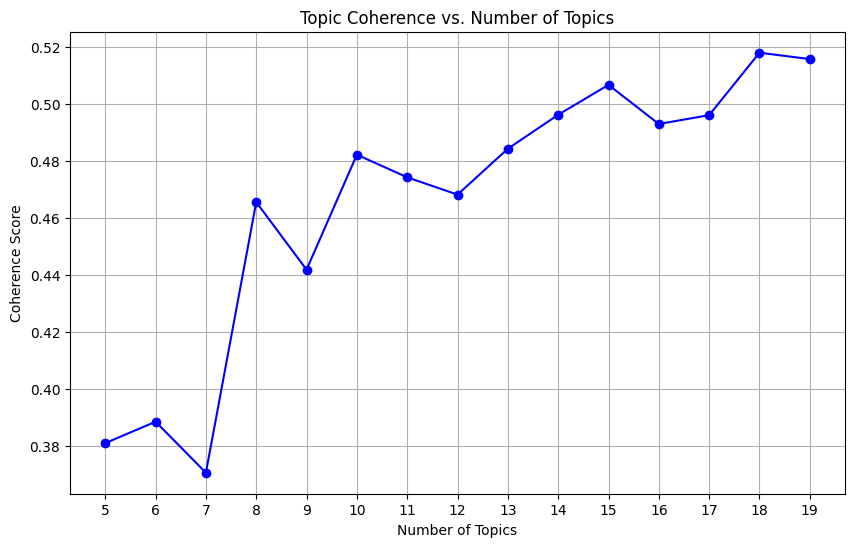

NameError: name 'np' is not defined

In [29]:
# Create a dictionary for the corpus (used by gensim)
processed_data = []
for data in cleaned_data:
    processed_data.append(data.split())
dictionary = Dictionary(processed_data)

# Convert the processed data into a corpus of BoW format (gensim)
corpus = [dictionary.doc2bow(text) for text in processed_data]

# Function to compute coherence score for a given number of topics
def compute_coherence_score(n_topics, corpus, dictionary, texts):
    # Train the LDA model using sklearn, but convert corpus into DTM format
    # Convert gensim corpus into a document-term matrix (DTM)
    dtm = gensim.matutils.corpus2dense(corpus, num_terms=len(dictionary)).T
    dtm = sp.csc_matrix(dtm)  # Convert to a sparse matrix
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_model.fit(dtm)
    
    # Get the top words for each topic from sklearn model
    feature_names = lda_model.components_
    top_words = []
    for topic_idx, topic in enumerate(feature_names):
        top_words.append([dictionary[id] for id in topic.argsort()[:-11:-1]])  # Get top 10 words per topic
    
    # Compute the coherence score using Gensim
    coherence_model = CoherenceModel(topics=top_words, corpus=corpus, dictionary=dictionary, texts=texts, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

# Range of topics to test (you can adjust this range based on your data)
topic_range = range(5, 20)
coherence_scores = []

# Calculate coherence score for each number of topics
for n_topics in topic_range:
    score = compute_coherence_score(n_topics, corpus, dictionary, processed_data)  # pass processed_data as texts
    coherence_scores.append(score)
    print(f"Number of topics: {n_topics}, Coherence Score: {score:.4f}")

# Plot the coherence scores
plt.figure(figsize=(10, 6))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-', color='b')
plt.title('Topic Coherence vs. Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(topic_range)
plt.grid(True)
plt.show()

# Print the best number of topics based on the highest coherence score
best_num_topics = topic_range[np.argmax(coherence_scores)]
print(f"The best number of topics based on coherence score is: {best_num_topics}")

## Topics

In [33]:
# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    # max_df=0.90,  # Exclude words that appear in more than x% of documents
    # min_df=1, # Exclude words that appear in fewer than x documents
    max_features=1000)
X = vectorizer.fit_transform(cleaned_data)

from sklearn.decomposition import LatentDirichletAllocation

# Fit LDA model (set number of topics)
lda = LatentDirichletAllocation(
    n_components=8,
    max_iter=1000,
    learning_decay=0.7,
    doc_topic_prior=0.3,  # helps reduce dominance of a single topic
    topic_word_prior=0.1,  # controls the spread of words across topics
    random_state=27)
lda.fit(X)

LatentDirichletAllocation(doc_topic_prior=0.3, max_iter=1000, n_components=8,
                          random_state=27, topic_word_prior=0.1)

In [34]:
# Get the top words for each topic
num_words = 10
words = vectorizer.get_feature_names_out()

for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}:")
    print([words[i] for i in topic.argsort()[:-num_words - 1:-1]])

Topic #0:
['communicating', 'association', 'aim', 'astrophysical', 'post', 'apart', 'tried', 'sector', 'lower', 'rule']
Topic #1:
['communicating', 'association', 'aim', 'astrophysical', 'post', 'apart', 'tried', 'sector', 'lower', 'rule']
Topic #2:
['communicating', 'association', 'aim', 'astrophysical', 'post', 'apart', 'tried', 'sector', 'lower', 'rule']
Topic #3:
['communicating', 'association', 'aim', 'astrophysical', 'post', 'apart', 'tried', 'sector', 'lower', 'rule']
Topic #4:
['communicating', 'association', 'aim', 'astrophysical', 'post', 'apart', 'tried', 'sector', 'lower', 'rule']
Topic #5:
['different', 'country', 'thing', 'year', 'question', 'time', 'international', 'paper', 'working', 'learning']
Topic #6:
['communicating', 'association', 'aim', 'astrophysical', 'post', 'apart', 'tried', 'sector', 'lower', 'rule']
Topic #7:
['communicating', 'association', 'aim', 'astrophysical', 'post', 'apart', 'tried', 'sector', 'lower', 'rule']


In [35]:
# Get the topic distribution for each document
topic_distribution = lda.transform(X)

# Show the topic with the highest probability for each document
for doc_idx, topic_probs in enumerate(topic_distribution):
    # print(f"Document #{doc_idx} - Predicted Topic: {topic_probs.argmax()} with probability {topic_probs.max():.3f}")
    print(f"Document {doc_idx+1}: Top topic {topic_probs.argmax()} with probability {topic_probs.max():.4f}")

Document 1: Top topic 5 with probability 0.8729
Document 2: Top topic 5 with probability 0.8788
Document 3: Top topic 5 with probability 0.8862
Document 4: Top topic 5 with probability 0.8782
Document 5: Top topic 5 with probability 0.8448
Document 6: Top topic 5 with probability 0.9001
Document 7: Top topic 5 with probability 0.8914
Document 8: Top topic 5 with probability 0.8400
Document 9: Top topic 5 with probability 0.8964
Document 10: Top topic 5 with probability 0.8725
Document 11: Top topic 5 with probability 0.8821
Document 12: Top topic 5 with probability 0.8859


# NMF

## Num Topics

Number of topics: 1, Coherence Score: 0.3684
Number of topics: 2, Coherence Score: 0.3844
Number of topics: 3, Coherence Score: 0.4150
Number of topics: 4, Coherence Score: 0.4214
Number of topics: 5, Coherence Score: 0.4626
Number of topics: 6, Coherence Score: 0.4728
Number of topics: 7, Coherence Score: 0.4671
Number of topics: 8, Coherence Score: 0.4805
Number of topics: 9, Coherence Score: 0.4597


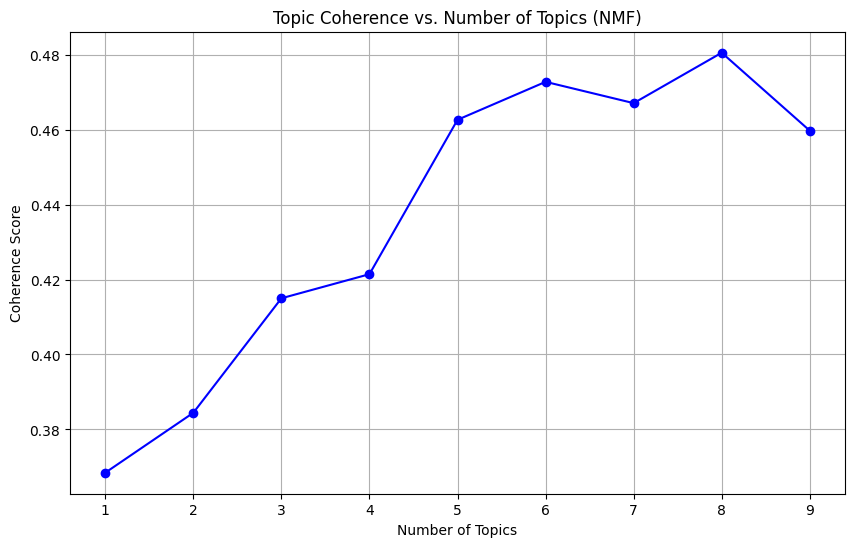

The best number of topics based on coherence score is: 8


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import scipy.sparse as sp

# Preprocessing: Convert cleaned data into document-term matrix (DTM)
vectorizer = TfidfVectorizer(
    max_df=0.95,  # Exclude words in >95% of documents
    min_df=2,     # Exclude words in <2 documents
    max_features=1200,
    ngram_range=(1, 2),  # Limit the number of features
    stop_words='english'  # Use standard stopwords
)
dtm = vectorizer.fit_transform(cleaned_data)

# Create Gensim dictionary and corpus for coherence computation
processed_data = [text.split() for text in cleaned_data]
dictionary = Dictionary(processed_data)
corpus = [dictionary.doc2bow(text) for text in processed_data]

# Function to compute coherence score for NMF
def compute_coherence_nmf(n_topics, dtm, dictionary, corpus, texts):
    # Train NMF model
    nmf_model = NMF(n_components=n_topics, random_state=42)
    nmf_model.fit(dtm)
    
    # Extract top words for each topic
    feature_names = vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]  # Top 10 words
        topics.append(top_words)
    
    # Compute coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

# Range of topics to test
topic_range = range(1, 10)
coherence_scores = []

# Calculate coherence score for each number of topics
for n_topics in topic_range:
    score = compute_coherence_nmf(n_topics, dtm, dictionary, corpus, processed_data)
    coherence_scores.append(score)
    print(f"Number of topics: {n_topics}, Coherence Score: {score:.4f}")

# Plot the coherence scores
plt.figure(figsize=(10, 6))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-', color='b')
plt.title('Topic Coherence vs. Number of Topics (NMF)')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(topic_range)
plt.grid(True)
plt.show()

# Identify the best number of topics
best_num_topics = topic_range[np.argmax(coherence_scores)]
print(f"The best number of topics based on coherence score is: {best_num_topics}")

In [41]:
# Fit NMF model with the best number of topics
nmf_final = NMF(n_components=best_num_topics, random_state=42)
W_final = nmf_final.fit_transform(dtm)  # Document-topic matrix
H_final = nmf_final.components_  # Topic-term matrix
nmf_final

NMF(n_components=8, random_state=42)

In [42]:
num_top_words = 10
vocab_size = len(feature_names)

print("\nTopics and Top Words (NMF):")
for topic_idx, topic in enumerate(H_final):
    top_indices = [i for i in topic.argsort()[:-num_top_words - 1:-1] if i < vocab_size]  
    top_words = [feature_names[i] for i in top_indices]
    print(f"Topic #{topic_idx + 1}: {', '.join(top_words)}")



Topics and Top Words (NMF):
Topic #1: aggression, appliable, 21st, capital, agent, assuming, census, chasing, car, cheating
Topic #2: bernard, astrophysic, busy, background, aa, astroparticle, 19th, admire, accomplish, benchmarke
Topic #3: adaptive, astrophysical, biased, bore, assure, carry, chemic, borderless, bos, asteroid
Topic #4: adopter, appease, aggression, appear, assure, chronic, amazed, accurately, billing, backseat
Topic #5: apply, adopter, anyone, advance, aggression, build, bur, boost, bangladesh, amateur
Topic #6: 60, adopter, biased, cardiology, bur, carefully, assure, board, amazed, bing
Topic #7: aggression, biometrika, adopter, adolescent, bite, barack, appliable, 10year, belief, analogy
Topic #8: acting, accurately, assure, aggression, adopter, biased, art, anyone, appropriate, carefully


In [43]:
# Assign the top topic to each document
document_topics = W_final.argmax(axis=1)

# Display the top topic for each document
print("\nTop Topics for Each Document:")
for doc_idx, topic in enumerate(document_topics):
    print(f"Document {doc_idx + 1}: Topic {topic + 1}")



Top Topics for Each Document:
Document 1: Topic 8
Document 2: Topic 6
Document 3: Topic 4
Document 4: Topic 5
Document 5: Topic 2
Document 6: Topic 1
Document 7: Topic 7
Document 8: Topic 3
Document 9: Topic 1
Document 10: Topic 7
Document 11: Topic 1
Document 12: Topic 4


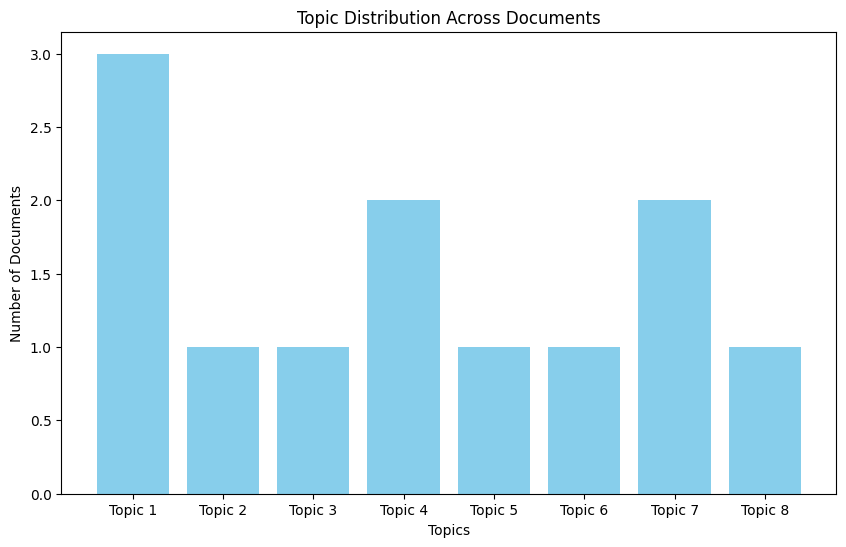

In [44]:
# Count occurrences of each topic
topic_counts = Counter(document_topics)

# Plot the topic distribution
plt.figure(figsize=(10, 6))
plt.bar(topic_counts.keys(), topic_counts.values(), color='skyblue')
plt.xticks(range(best_num_topics), [f"Topic {i + 1}" for i in range(best_num_topics)])
plt.xlabel("Topics")
plt.ylabel("Number of Documents")
plt.title("Topic Distribution Across Documents")
plt.show()


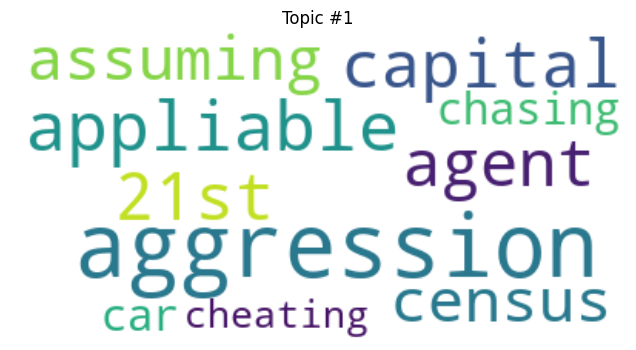

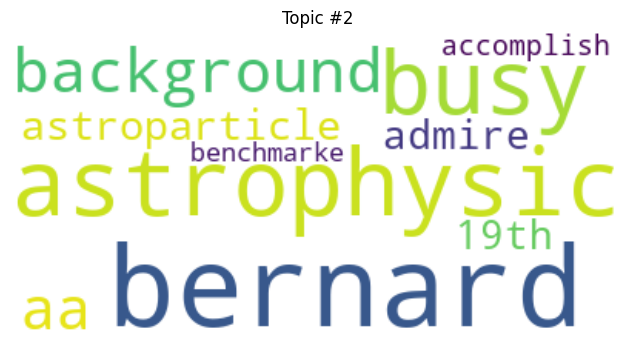

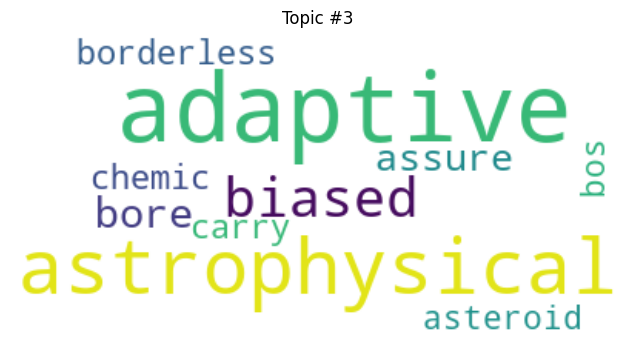

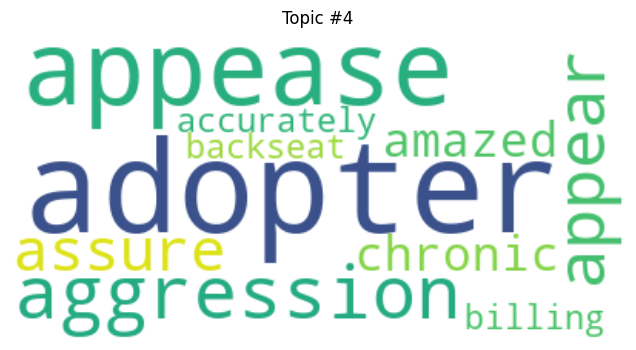

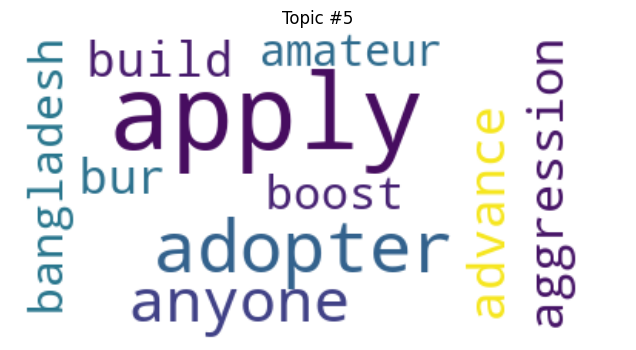

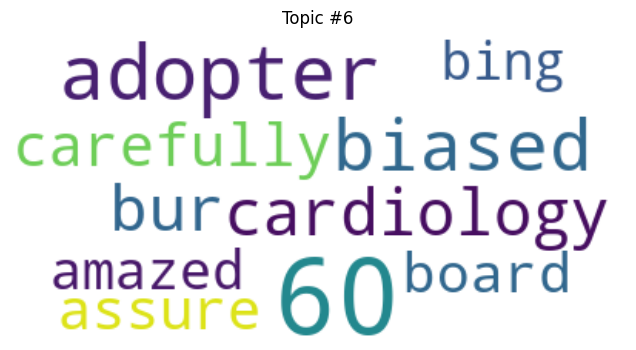

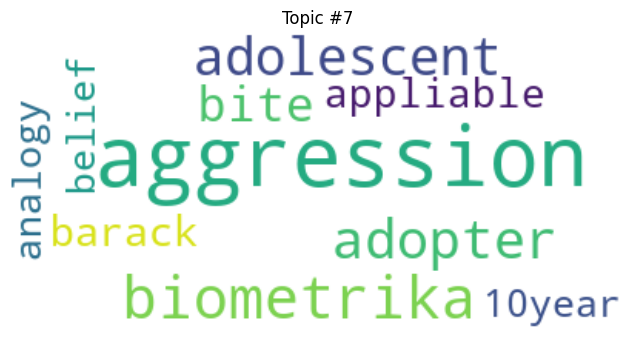

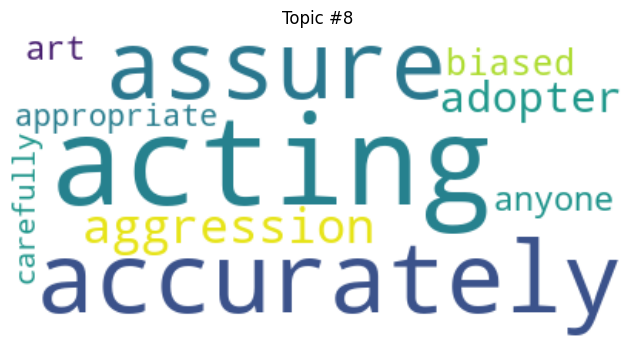

In [45]:
# Generate and display a word cloud for each topic
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for topic_idx, topic in enumerate(H_final):
    top_indices = [i for i in topic.argsort()[:-num_top_words - 1:-1] if i < len(feature_names)]
    top_words = {feature_names[i]: topic[i] for i in top_indices}
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(top_words)
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic #{topic_idx + 1}")
    plt.show()
